# LANL Notebook

Link to competition and dataset: https://www.kaggle.com/c/LANL-Earthquake-Prediction


## The Dataset
The training dataset has 2 columns (x, y), representing a single, continuous seismic signal.  x is the signal value, and y is the time-to-next-earthquake. The test data consists of segments of seismic signals (x values), and for each signal point in a segment, a time-to-next-earthquake (y) must be predicted by a machine learning model.

The dataset is large with over 600 million data points in the training signal (9 GB in csv format) and working with it will prove to be challenging (loading, visualizing, training models etc.).


In [1]:
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
%matplotlib inline  

In [2]:
#Data was convereted from CSV to HDF then truncated,
hdf_key = 'my_key'
#num_rows_to_keep = 139000000    # 22% out of 620 million rows (captures 4 earthquakes)
truncated_train_hdf_file = '../LANL-Earthquake-Prediction/truncated_train_hdf.h5' # Change to point to proper local path

In [3]:
def read_hdf(filename, key):
    t0 = time.time()
    print('Reading HDF dataset {}'.format(filename))

    dataset_df = pd.read_hdf(filename, key=key)

    print('Reading {} complete. time_to_read={}'.format(filename, time.time() - t0))

    return dataset_df  # This is a Pandas DataFrame

In [4]:
def print_info(df):
    print("Dataset shape = {}".format(df.shape))
    df.info(memory_usage='deep')    # Some info about the dataset (memory usage etc.)

    pd.set_option("display.precision", 15)  # Show more decimals
    print(df.head())

    # print(df.acoustic_data.describe())  # Some stats; can take time if dataset is large


def truncate_dataset(df, num_rows_to_keep):
    print('Truncating the dataset. num_rows_to_keep={}'.format(num_rows_to_keep))
    trunc_df = df[:num_rows_to_keep]
    print('Truncating complete. trunc_df.shape={}'.format(trunc_df.shape))
    return trunc_df

In [5]:
def plot_series(df):
    print('Plotting series')
    # plt.plot(series)
    # plt.show()

    fig, ax1 = plt.subplots()

    color = 'tab:orange'
    ax1.set_xlabel('time (#points)')
    ax1.set_ylabel('seismic_signal', color=color)
    ax1.plot(df.acoustic_data, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('time_to_earthquake', color=color)  # we already handled the x-label with ax1
    ax2.plot(df.time_to_failure, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

## Import Truncated Data from hdf file

In [6]:
train_df = read_hdf(truncated_train_hdf_file, hdf_key)

Reading HDF dataset ../LANL-Earthquake-Prediction/truncated_train_hdf.h5
Reading ../LANL-Earthquake-Prediction/truncated_train_hdf.h5 complete. time_to_read=6.561606168746948


### Samer->Sunanda: Can we have another dataset for validation (say: valid_df), please? 

In [7]:
print_info(train_df)

Dataset shape = (139000000, 2)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 139000000 entries, 0 to 138999999
Data columns (total 2 columns):
acoustic_data      int16
time_to_failure    float64
dtypes: float64(1), int16(1)
memory usage: 2.3 GB
   acoustic_data  time_to_failure
0             12     1.4690999832
1              6     1.4690999821
2              8     1.4690999810
3              5     1.4690999799
4              8     1.4690999788


Plotting series


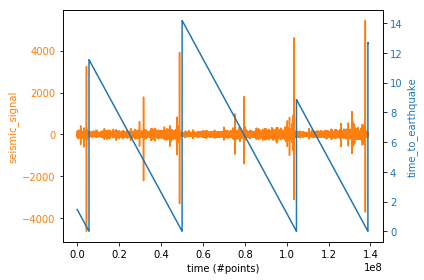

In [8]:
plot_series(train_df)

# Understanding Data

## Domain Perspective

### Overview

https://www.youtube.com/watch?v=T0AEtX-uPLA
- Earthquakes occur when two parts of the earth suddenly move in relation to each other. 
- Earthequake originates at a point in earth called focus and spreads up to the surface at a point called Epicenter.
- A seismograph detects and records seismic waves. 
- Types of Seismic waves include:  Pressure (or Primary) Waves (P-Waves), Shear (or Secondary) Waves (S-Waves) and Surface Waves. P-Waves and S-Waves are both Body waves.

https://courses.lumenlearning.com/geophysical/chapter/earthquake-prediction/
- Predciting when an earthquake will occur is more difficult than predicting where it will occur.
- Sometimes (not always) earthquakes occur few seconds to few weeks after foreshocks.

https://en.wikipedia.org/wiki/P-wave
- P-Wave travel faster and hence are the first waves to reach sesimograph. They propagate through gases, liguids or solids. 
- S-Waves are attenuated by liquids.
- P-Waves are non-destructive, while both S-Waves and Surfcae Waves are destructive. 
- Earthquake warning is possible if P-Waves are detected. Advanced warning time is dependent on the delay beween the arrival of P-wave and the arrival of the first destructive waves. This delay is a function of how deep the fous is, nature of earth layers and others. It ranges from few seconds to 90 seconds. Ground vibrations resulting from truck movement and contruction activitoes on earth shall be rejected for accurate detection of P-waves. 

https://www.bgs.ac.uk/discoveringGeology/hazards/earthquakes/

A typical seismogram is shown below:

![title](figures/dia_seismogram.jpg)

From the seismogram, we notice that the P-wave arrives first. Since both S-wave and Surface wave are destructive, and for useful prediction of an earthquake, we need to focus on detetcting the P-wave. Observing the plot for kaggle's data, we notice that the large peaks occur just before the time-to-failure reaches zero. We interpret these peaks as the surface waves and hence it is imprtant to on the data points preceding the peaks. However, our window shall not include the previous peak.

 


## Statistical Perspective

Basic analysis is given in : https://www.kaggle.com/jsaguiar/seismic-data-exploration
From analysis above, we can summarize the following:
- time_to_failure: min value: 0.000096, max value: 16.11, mean: 5.6783
- signal amplitude: min: -5515, max: 5444, Mean 4.52
- A huge spike in acoustic data around half second before the earthquake. The analyst consider a a value of 500 as a cut-off to distinguish peaks from the rest of acoustic data points. Occasionally, time_to_fault may go as high as 9 sec after such peaks.

https://towardsdatascience.com/how-not-to-use-machine-learning-for-time-series-forecasting-avoiding-the-pitfalls-19f9d7adf424
https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

Check if series is Random Walk abd/or stationary:

https://youtu.be/MZvgHIFD31k

https://www.quora.com/Is-a-random-walk-the-same-thing-as-a-non-stationary-time-series

We need to test data for random-walk/stochasiticity, e.g. correlation tests on both signal (f) and (df), covariance test?!

# Recurrent Neural Network - LSTM

## Part 1 - Data Preprocessing

In [75]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [65]:
# Importing the training set
dataset_train = train_df
training_set = dataset_train.iloc[:, 0:2].values

In [66]:
# Feature Scaling - Ignored for now
"""
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler (feature_range=(0, 1))
training_set_scaled = sc.fit_transform (training_set) 
"""
training_set_scaled=training_set

In [73]:
# Creating a data structure with 1000 timesteps and 1 output
X_train = []
y_train = []

"""
Temporary: we reduce the datatset by 400 to exceuste fast!
Temporary: 1000 (steps in the past) is picked randomly while it should be carefully studied
"""
    
for i in range (1000, int(train_df.shape[0]/400)): 
    X_train.append (training_set_scaled[i - 1000:i, 0])
    y_train.append (training_set_scaled[i, 1])
X_train, y_train = np.array (X_train), np.array (y_train)

# Reshaping
X_train = np.reshape (X_train, (X_train.shape[0], X_train.shape[1], 1))

## Part 2 - Building the RNN

In [74]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# Initialising the RNN
regressor = Sequential ()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add (LSTM (units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
regressor.add (Dropout (0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add (LSTM (units=50, return_sequences=True))
regressor.add (Dropout (0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add (LSTM (units=50, return_sequences=True))
regressor.add (Dropout (0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add (LSTM (units=50))
regressor.add (Dropout (0.2))

# Adding the output layer
regressor.add (Dense (units=1))

# Compiling the RNN
regressor.compile (optimizer='adam', loss='mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit (X_train, y_train, epochs=100, batch_size=32)

Using TensorFlow backend.


Epoch 1/100
   736/346500 [..............................] - ETA: 16:38:22 - loss: 0.3941

KeyboardInterrupt: 

## Part 3 - Making the predictions and visualising the results

We need the validation dataset!